In [3]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from pathlib import Path

from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg

import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *

import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
import common_vars as comv

import csv
import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
imp.reload(tm)
from helpers import *

from common_vars import SR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path="./generated_sample_pack/"
# device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}

drum_groups=['tom_low','snare','hihat_closed','rim','synth_noise','clap','kick','hihat_open','tom_mid']

drum_df=pd.DataFrame(columns=["name","fc","cnnlstm","env+freq","consensus","stack_size"])

In [85]:
import feature_extraction.pytorch_models as pm
import imp

imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1

    
#########DVN#########
#env model stuff
env_model_dvn = tm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='../feature_extraction/models/fc/env_dvn_95_35.pt'
env_model_dvn.load_state_dict(torch.load(state))
env_trans=tm.envTrans()
env_model_dvn.to(device)


# pitch model stuff
fc_spec_model_dvn=tm.getFCSpecModel(D_in=20*20,H1=20,H2=10,H3=4,D_out=2)
state='../feature_extraction/models/fc/spec_fc_dvn_96.pt'
fc_spec_model_dvn.load_state_dict(torch.load(state))
fc_spec_trans_dvn=tm.specTrans(20)
fc_spec_model_dvn.to(device)

#cnn lstm
cnn_model_dvn=pm.CNNLSTM_dvn()
state='../feature_extraction/models/cnn/clst_dvn_96_279.pt'
cnn_model_dvn.load_state_dict(torch.load(state))
cnn_model_dvn.to(device)
cnn_model_dvn.to(device)
#########DVD#########
#fc dvd
dvd_fc=pm.getFCSpecModel(D_in=20*20,H1=100,H2=50,H3=100,D_out=len(drum_groups))
state='../feature_extraction/models/fc/spec_fc_dvd_81.pt'
dvd_fc.load_state_dict(torch.load(state))
dvd_fc.to(device)

#cnn_dvd
dvd_cnn=pm.CNNLSTM_dvd(len_out=len(drum_groups))
state='../feature_extraction/models/cnn/clst_dvd_90_170.pt'
dvd_cnn.load_state_dict(torch.load(state))
dvd_cnn.to(device)

#freq+env model
freq_env_model_dvd = tm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,D_out=len(drum_groups))
state='../feature_extraction/models/fc/freq_env_dvd_86_351.pt'
freq_env_model_dvd.load_state_dict(torch.load(state))
freq_env_trans=tm.freq_and_env_Trans(feat_mels=50,env_mels=1)
freq_env_model_dvd.to(device)



from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)


env score 0.7685750722885132
fc_spec 0.0050766500644385815
o_cnn_spec 0.00017552584176883101
fc category synth_noise 
cnn category synth_noise 
env+freq snare
total consensus synth_noise
it took 25 iteration, stack size 2


<Figure size 864x216 with 0 Axes>

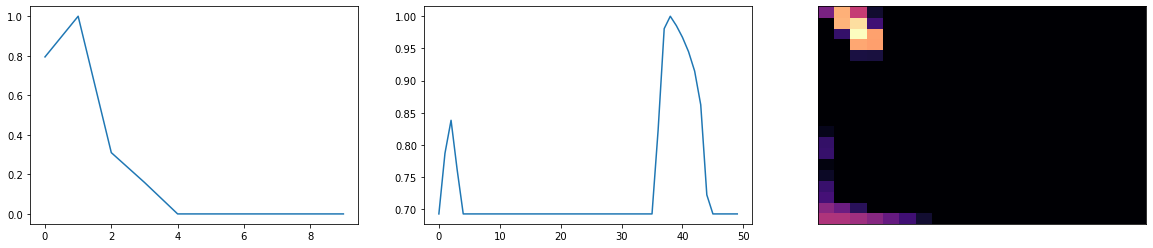

In [88]:
def evalSoundSlow(a):
    try:
        a=librosa.util.normalize(a)
    except:
        pass
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)

    outputEnvFreq=freq_env_model_dvd(freq_feats)
    outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
    outputFCDVD=dvd_fc(spec_flat)
    outputE=env_model_dvn(env_feats)
    outputSPECFC=fc_spec_model_dvn(spec_flat)
    outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    if (o_e>=0.5) or (o_e>0.5 and o_cnn_spec>0.7):
        print("env score",o_e)
        print("fc_spec",o_fc_spec)
        print("o_cnn_spec",o_cnn_spec)
        print("fc category",gfc,"\ncnn category",gcnn,"\nenv+freq",genvfreq)
        print("total consensus",cat_consensus)
        
        return(a,env_feats,freq_feats,pitch_feats,stack_size,"found")
    return (a,env_feats,freq_feats,pitch_feats,stack_size,"not_found")

def findDrum(stack_size=1,iteration=0):
    out,params= stackMaker(stack_size)
    a= memToAud(out)
    return evalSoundSlow(a)
i=0
j=0
while i<10000000:
    i=i+1
    j=j+1
    stack_size=np.random.choice([2])
    (a,env_feats,freq_feats,pitch_feats,stack_size,results)=findDrum(stack_size,iteration=i)
    if results!="not_found":
        print("it took %d iteration, stack size %d"%(j,stack_size))
        j=0
        break

fig = plt.figure(figsize=(12,3))
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(1, 3,1)

plt.plot(env_feats)
ax = plt.subplot(1, 3,2)
plt.plot(freq_feats[0:50])
ax=plt.subplot(1,3,3)
ft=pitch_feats
ft=ft.numpy()
librosa.display.specshow(ft[0])
Audio(a,rate=sr, autoplay=True)

In [92]:
def evalSound(a):
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)


    outputEnvFreq=freq_env_model_dvd(freq_feats)
    outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
    outputFCDVD=dvd_fc(spec_flat)
    outputE=env_model_dvn(env_feats)
    outputSPECFC=fc_spec_model_dvn(spec_flat)
    outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
#     print("env score",o_e)
#     print("fc_spec",o_fc_spec)
#     print("o_cnn_spec",o_cnn_spec)
#     print("fc category",gfc,"\ncnn category",gcnn,"\nenv+freq",genvfreq)
#     print("total consensus",cat_consensus)
        
#     return(a,env_feats,freq_feats,pitch_feats,stack_size,"found")
    return o_e
    

def findDrum(stack_size=1,iteration=0):
    out,params= stackMaker(stack_size)
    a= memToAud(out)
    return a,evalSoundSolo(a)

a,sc=findDrum(stack_size,iteration=i)


print(sc)
Audio(a,rate=sr, autoplay=True)

2.0648535168355852e-23
